In [117]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer,Conv2D,Dense,MaxPool2D,Flatten , BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [118]:
dataset,dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

In [119]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [54]:
# testing function to build own splitter
TRAIN_RATIO = 0.6
TEST_RATIO = 0.2
VAL_RATIO = 0.2

dataset = tf.data.Dataset.range(10)
print(list(dataset.as_numpy_iterator()))
DATASET_SIZE = len(dataset)

train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
print(list(train_dataset.as_numpy_iterator()))

val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
print(list(val_dataset.as_numpy_iterator()))

test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
print(list(test_dataset.as_numpy_iterator()))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[6, 7, 8, 9]


In [120]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [145]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

train_dataset,val_dataset,test_dataset= splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)

In [122]:
for data in dataset[0].take(3):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(106, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

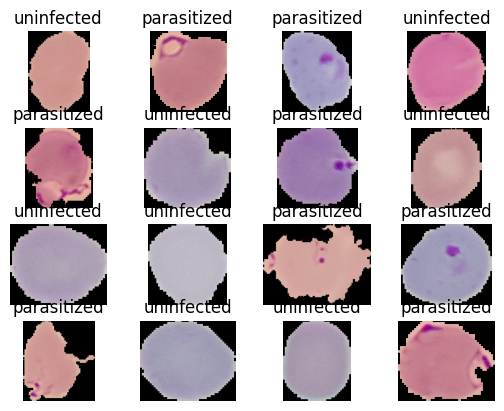

In [123]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [146]:
IMAGE_SIZE = 224
def resizing(image,label):
  return tf.image.resize(image,(IMAGE_SIZE,IMAGE_SIZE))/255.0,label

In [147]:
train_dataset = train_dataset.map(resizing)
test_dataset = test_dataset.map(resizing)
val_dataset = val_dataset.map(resizing)

In [139]:
for d in train_dataset.take(3):
  print(d)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int6

In [148]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [149]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [150]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [151]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [152]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [129]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),
    Conv2D(filters=6,kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),

    Conv2D(filters=16,kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),

    Flatten(),

    Dense(100,activation="relu"),
    BatchNormalization(),
    Dense(10,activation="relu"),
    BatchNormalization(),
    Dense(1,activation="sigmoid")


])
lenet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

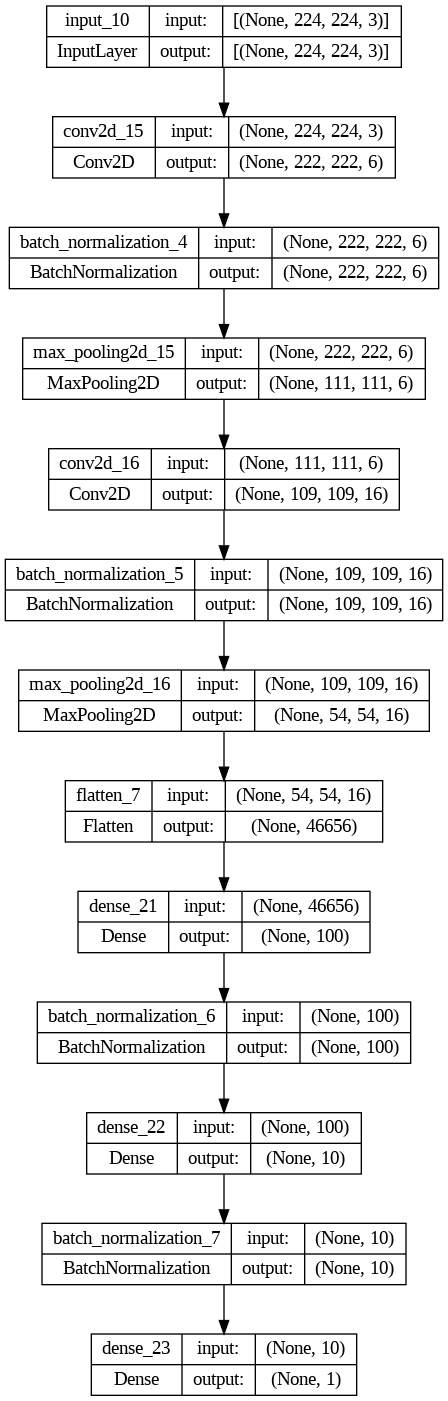

In [130]:
tf.keras.utils.plot_model(lenet_model,to_file='model_1.png',show_shapes=True)

In [131]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics='accuracy'
              )

In [153]:
history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 42s 60ms/step - loss: 0.2206 - accuracy: 0.9235 - val_loss: 0.4613 - val_accuracy: 0.8421
Epoch 2/20
689/689 [==============================] - 54s 78ms/step - loss: 0.2577 - accuracy: 0.9077 - val_loss: 1.6025 - val_accuracy: 0.4966
Epoch 3/20
689/689 [==============================] - 49s 71ms/step - loss: 0.2577 - accuracy: 0.9098 - val_loss: 7.5997 - val_accuracy: 0.8791
Epoch 4/20
689/689 [==============================] - 44s 64ms/step - loss: 0.2026 - accuracy: 0.9322 - val_loss: 0.1872 - val_accuracy: 0.9350
Epoch 5/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1708 - accuracy: 0.9418 - val_loss: 0.1574 - val_accuracy: 0.9441
Epoch 6/20
689/689 [==============================] - 40s 58ms/step - loss: 0.1593 - accuracy: 0.9479 - val_loss: 0.1803 - val_accuracy: 0.9441
Epoch 7/20
689/689 [==============================] - 41s 60ms/step - loss: 0.1519 - accuracy: 0.9499 - val_loss: 0.1607 - val_accuracy:

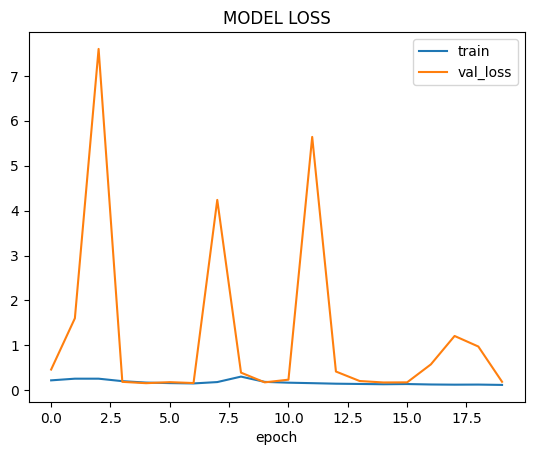

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MODEL LOSS')
plt.xlabel('epoch')
plt.legend(['train','val_loss'])
plt.show()

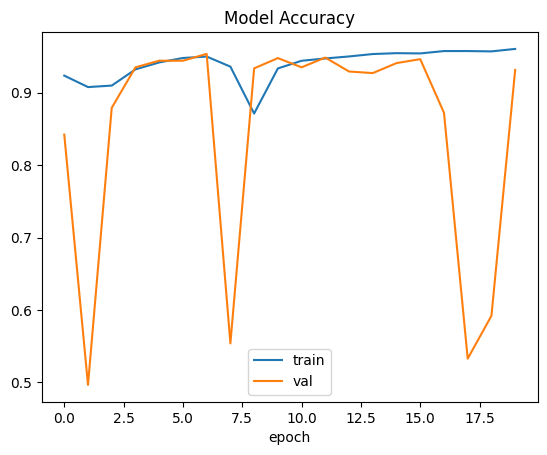

In [155]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

In [156]:
test_dataset = test_dataset.batch(1)

In [158]:
lenet_model.evaluate(test_dataset)

5512/5512 [==============================] - 30s 4ms/step - loss: 0.2001 - accuracy: 0.9307


[0.20005926489830017, 0.9306966662406921]

In [161]:
ch(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 8s 8s/step


'parasite'

In [160]:
def ch(x):
  if(x<0.5):
    return str('parasite')
  else:
    return "uneffected"

1/1 [==============================] - 0s 18ms/step


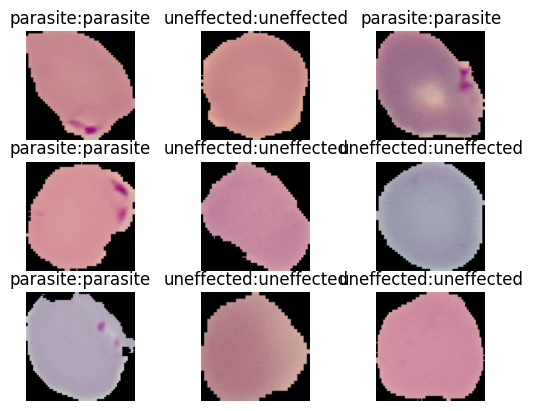

In [163]:
for i, (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(ch(label.numpy()[0]))+":" + str(ch(lenet_model.predict(image)[0][0])))
  plt.axis('off')

In [164]:
lenet_model.save("lenet")

In [165]:
lenet_model.save("lenet.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
